## This is Classification Model Training for DDR dataset. This model uses Densenet-121 a pretrained model.



### STEPS for model training
##### Step 1. Define Preprocessing Function 
###### Median Filtering, CLAHE, Gamma Correction, ESRGAN(optional)
##### Step 2. Create Custom Dataset for preprocessing (Pytorch doesn't supports Custom Preprocessing)
##### Step 3. Define Transform (with data augmentation)
##### Step 4. Create datasets and Dataloaders
##### Step 5. Load DenseNet-121 Model
##### Step 6. Define Loss, Optimizer, Scheduler
##### Step 7. Model Training
##### Step 8. Validation and Evaluation
##### Step 9. Save the Model

## Dataset Descrption

### DDR dataset contains 13,673 fundus images from 147 hospitals, covering 23 provinces in China. The images are classified into 5 classes according to DR severity: none, mild, moderate, severe, and proliferative DR. There is a sixth category which indicates the images with poor quality. The dataset presented here does not include the images with poor quality (sixth category) and all images have been preprocessed to delete the black background. https://www.kaggle.com/datasets/mariaherrerot/ddrdataset

### Import Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import shutil 
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

## Load and split to train_test_val DDR Dataset

In [2]:
# Load CSV
df = pd.read_csv("D:\\DR_Classification\\dataset\\DR_grading.csv")
df['image_path'] = df['id_code'].apply(lambda x: os.path.join("D:\\DR_Classification\\dataset\\images", x))
df['label'] = df['diagnosis']

# Create output directories
output_root = "D:\\DR_Classification\\splits"
os.makedirs(os.path.join(output_root, "train"), exist_ok=True)
os.makedirs(os.path.join(output_root, "test"), exist_ok=True)

# Split: train vs test
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# Function to copy images and save CSV
def save_split(df_split, split_name):
    split_folder = os.path.join(output_root, split_name)
    new_paths = []

    # Check if the CSV for the current split already exists
    csv_path = os.path.join(output_root, f"{split_name}_labels.csv")
    if os.path.exists(csv_path):
        print(f"{split_name}_labels.csv already exists. Skipping this split.")
        return  # Skip processing if the CSV file exists

    # Proceed with copying images and saving the new CSV if the CSV does not exist
    for _, row in df_split.iterrows():
        src = row['image_path']
        dst = os.path.join(split_folder, os.path.basename(src))

        if os.path.exists(src):
            shutil.copy(src, dst)
            new_paths.append(dst)
        else:
            print(f"Warning: Missing image file {src}")

    df_split = df_split.copy()
    df_split['new_path'] = new_paths
    df_split[['id_code', 'label', 'new_path']].to_csv(csv_path, index=False)
    print(f"{split_name}_labels.csv saved successfully!")

# Save each split
save_split(train_df, "train")
save_split(test_df, "test")

print("Splits and CSVs checked and saved successfully!")

train_labels.csv already exists. Skipping this split.
test_labels.csv already exists. Skipping this split.
Splits and CSVs checked and saved successfully!


In [3]:
print(df['image_path'].head())

0    D:\DR_Classification\dataset\images\2017041310...
1    D:\DR_Classification\dataset\images\2017041311...
2    D:\DR_Classification\dataset\images\2017041311...
3    D:\DR_Classification\dataset\images\2017041311...
4    D:\DR_Classification\dataset\images\2017041311...
Name: image_path, dtype: object


In [4]:
# Count samples per class in each split
print("Train class distribution:")
print(train_df['label'].value_counts())

print("\nTest class distribution:")
print(test_df['label'].value_counts())

# Count the total number of images in each split
print(f"Total: {len(df)} images")
print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train class distribution:
label
0    4386
2    3134
4     639
1     441
3     165
Name: count, dtype: int64

Test class distribution:
label
0    1880
2    1343
4     274
1     189
3      71
Name: count, dtype: int64
Total: 12522 images
Train: 8765
Test: 3757


In [15]:
# Load the split CSVs
train_df = pd.read_csv("D:/DR_Classification/splits/train_labels.csv")
test_df = pd.read_csv("D:/DR_Classification/splits/test_labels.csv")

# Extract paths and labels
train_paths = train_df['new_path'].tolist()
train_labels = train_df['label'].tolist()

test_paths = test_df['new_path'].tolist()
test_labels = test_df['label'].tolist()

### Step 1. Define Preprocessing Functions

In [16]:
def apply_median_filter(image):
    return cv2.medianBlur(image, 3)

def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_gamma_correction(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def apply_gaussian_filter(image, kernel_size=(5, 5), sigma=1.0):
    return cv2.GaussianBlur(image, kernel_size, sigma)


#### For the ESRGAN if applicable

In [7]:
# def apply_esrgan(image):
#     # Placeholder: You should replace with actual ESRGAN model output
#     return enhance_with_esrgan(image)

### Step 2. Create Custom Dataset

In [17]:
# Apply customary dataset
class DDRDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Preprocessing steps
        image = apply_median_filter(image)
        image = apply_clahe(image)
        image = apply_gamma_correction(image)
        
        # Apply Gaussian filter
        image = apply_gaussian_filter(image, kernel_size=(5, 5), sigma=1.0)

        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label


### Step 3. Define Transforms with data augmentations

In [18]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # Add vertical flip
    transforms.RandomRotation(degrees=15),  # Random rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet pretraining normalization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # this is the same as training
])


### Step 4. Create Datasets and Dataloaders

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Dataset class should accept image paths and labels
train_dataset = DDRDataset(train_paths, train_labels, transform=train_transform)
test_dataset = DDRDataset(test_paths, test_labels, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Step 5. Load DenseNet-121 model

In [21]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 5)  # DDR has 5 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

d:\DR_Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DR_Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Step 6. Define Loss, Optimizer, Scheduler, checkpoint

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

### Step 7. Train the Model

In [23]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=15, device='cuda'):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Add tqdm progress bar
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backpropagate
                optimizer.step()  # Update weights

                running_train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

                pbar.set_postfix(loss=running_train_loss / (batch_idx + 1), accuracy=correct_train / total_train * 100)
                pbar.update(1)  # Update progress bar

        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train * 100

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
        scheduler.step()  # Step the learning rate scheduler

# Call the function
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=15, device=device)

Epoch 1/15:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1/15: 100%|██████████| 274/274 [41:09<00:00,  9.01s/it, accuracy=68.1, loss=0.833]


Epoch 1/15
Train Loss: 0.8326 | Train Accuracy: 68.09%


Epoch 2/15: 100%|██████████| 274/274 [41:55<00:00,  9.18s/it, accuracy=73.7, loss=0.706]


Epoch 2/15
Train Loss: 0.7060 | Train Accuracy: 73.68%


Epoch 3/15: 100%|██████████| 274/274 [42:13<00:00,  9.25s/it, accuracy=75.8, loss=0.666]


Epoch 3/15
Train Loss: 0.6662 | Train Accuracy: 75.79%


Epoch 4/15: 100%|██████████| 274/274 [39:27<00:00,  8.64s/it, accuracy=76.9, loss=0.636]


Epoch 4/15
Train Loss: 0.6361 | Train Accuracy: 76.89%


Epoch 5/15: 100%|██████████| 274/274 [41:08<00:00,  9.01s/it, accuracy=77.7, loss=0.628]


Epoch 5/15
Train Loss: 0.6281 | Train Accuracy: 77.70%


Epoch 6/15: 100%|██████████| 274/274 [41:22<00:00,  9.06s/it, accuracy=80.3, loss=0.547]


Epoch 6/15
Train Loss: 0.5466 | Train Accuracy: 80.31%


Epoch 7/15: 100%|██████████| 274/274 [40:05<00:00,  8.78s/it, accuracy=81.5, loss=0.512]


Epoch 7/15
Train Loss: 0.5121 | Train Accuracy: 81.48%


Epoch 8/15: 100%|██████████| 274/274 [41:18<00:00,  9.05s/it, accuracy=82.5, loss=0.488]


Epoch 8/15
Train Loss: 0.4880 | Train Accuracy: 82.49%


Epoch 9/15: 100%|██████████| 274/274 [42:20<00:00,  9.27s/it, accuracy=82.7, loss=0.473]


Epoch 9/15
Train Loss: 0.4732 | Train Accuracy: 82.66%


Epoch 10/15: 100%|██████████| 274/274 [40:16<00:00,  8.82s/it, accuracy=83.2, loss=0.465]


Epoch 10/15
Train Loss: 0.4646 | Train Accuracy: 83.17%


Epoch 11/15: 100%|██████████| 274/274 [39:24<00:00,  8.63s/it, accuracy=85, loss=0.433]  


Epoch 11/15
Train Loss: 0.4328 | Train Accuracy: 85.01%


Epoch 12/15: 100%|██████████| 274/274 [39:36<00:00,  8.67s/it, accuracy=84.3, loss=0.438]


Epoch 12/15
Train Loss: 0.4381 | Train Accuracy: 84.26%


Epoch 13/15: 100%|██████████| 274/274 [38:42<00:00,  8.48s/it, accuracy=84.9, loss=0.427]


Epoch 13/15
Train Loss: 0.4268 | Train Accuracy: 84.93%


Epoch 14/15: 100%|██████████| 274/274 [39:57<00:00,  8.75s/it, accuracy=84.5, loss=0.429]


Epoch 14/15
Train Loss: 0.4288 | Train Accuracy: 84.50%


Epoch 15/15: 100%|██████████| 274/274 [43:25<00:00,  9.51s/it, accuracy=84.6, loss=0.43] 

Epoch 15/15
Train Loss: 0.4299 | Train Accuracy: 84.61%


In [ ]:
# # Training Loop
# num_epochs = 15
# for epoch in range(start_epoch, num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()

#         optimizer.step()

#         running_loss += loss.item()
#         _, preds = torch.max(outputs, 1)
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)

#     # Step the learning rate scheduler
#     scheduler.step()

#     # Calculate accuracy for this epoch
#     epoch_accuracy = 100 * correct / total
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

#     # Save checkpoint at the end of each epoch
#     save_checkpoint(epoch, model, optimizer, scheduler, running_loss)

### Step 8. Validate and Evaluate the Model

In [27]:
def evaluation_test_model(model, test_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Evaluating on Test Set") as pbar:
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                pbar.update(1)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total * 100
    return val_loss, val_acc

In [28]:
evaluation_test_model(model, test_loader, criterion, device=device)

Evaluating on Test Set: 100%|██████████| 118/118 [06:41<00:00,  3.41s/it]


(0.48240930410259864, 83.20468458876763)

### Step 9. Visualize predictions

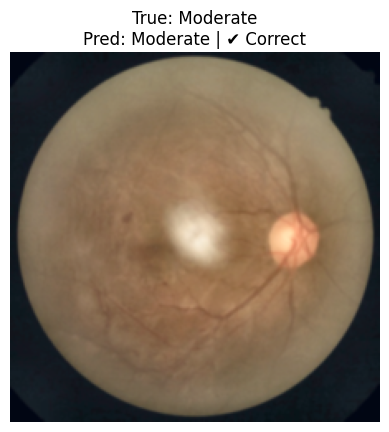

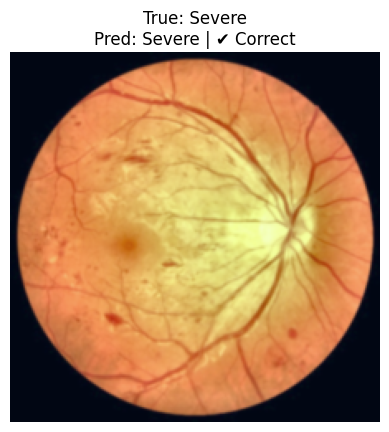

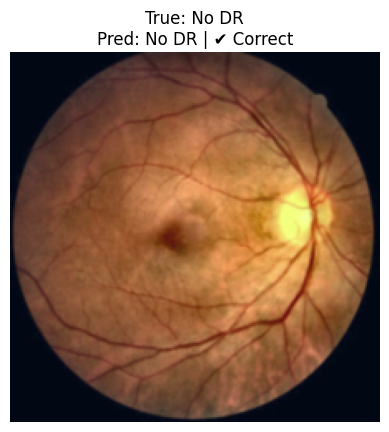

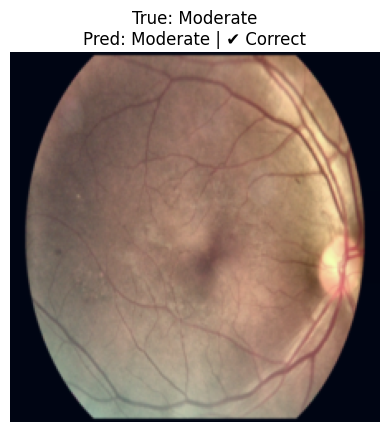

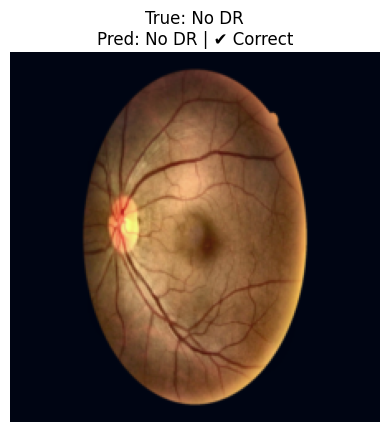

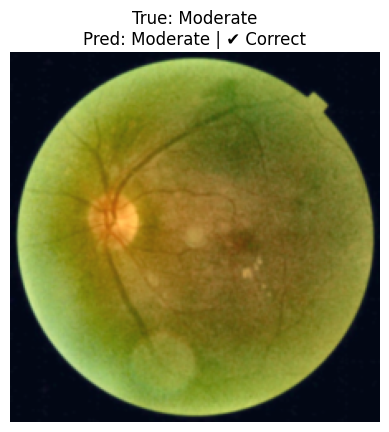

d:\DR_Classification\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


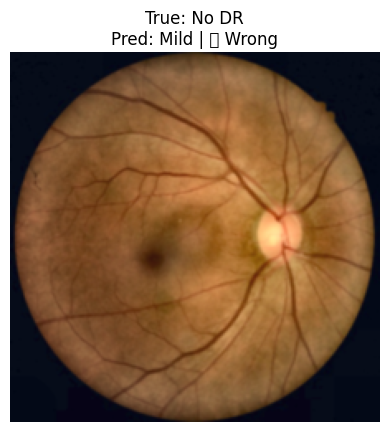

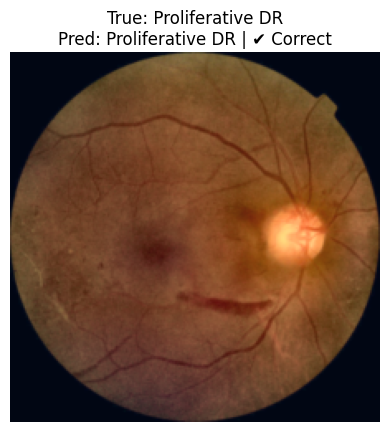


✅ Total Correct: 7/8 — Accuracy: 87.50%


In [31]:
def visualize_predictions(model, dataloader, class_names, device='cuda', num_images=6):
    model.eval()
    images_shown = 0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            inputs = inputs.cpu()
            labels = labels.cpu()
            preds = preds.cpu()

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    print(f"\n✅ Total Correct: {correct_preds}/{num_images} — Accuracy: {(correct_preds / num_images) * 100:.2f}%")
                    return

                img = inputs[i].permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())  # normalize for display

                is_correct = preds[i] == labels[i]
                correctness = "✔️ Correct" if is_correct else "❌ Wrong"
                if is_correct:
                    correct_preds += 1

                plt.imshow(img)
                plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]} | {correctness}")
                plt.axis("off")
                plt.show()

                images_shown += 1

    print(f"\n✅ Total Correct: {correct_preds}/{num_images} — Accuracy: {(correct_preds / num_images) * 100:.2f}%")

# Example usage
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
visualize_predictions(model, test_loader, class_names, device=device, num_images=8)

### Step 10. Save The Model

In [32]:
torch.save(model.state_dict(), "Pretrained_Densenet-121.pth")
print("✅ Final model saved as 'Pretrained Densenet 121.pth'")

✅ Final model saved as 'Pretrained Densenet 121.pth'


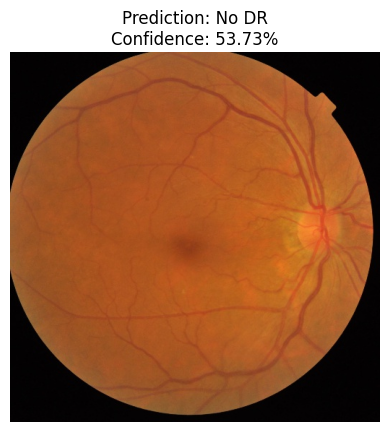

Predicted Class: No DR
Confidence: 53.73%


In [48]:
def predict_image(model, image_path, class_names, device='cuda'):
    # Load the image
    img = Image.open(image_path).convert("RGB")
    
    # Define the transformations (same as during training)
    transform = transforms.Compose([
        transforms.Resize(256),  # Resize the image
        transforms.CenterCrop(224),  # Crop the image
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize like ImageNet
    ])
    
    # Apply transformations
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Set model to evaluation mode
    model.eval()
    
    # Disable gradient computation for prediction
    with torch.no_grad():
        # Forward pass
        outputs = model(img_tensor)
        
        # Get the predicted class and confidence score (probability)
        _, preds = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)  # Get the softmax probabilities
        confidence_percentage = 100 * confidence[0][preds.item()]  # Confidence for the predicted class

    # Get the class name
    predicted_class = class_names[preds.item()]
    
    # Plot the image and show prediction with confidence
    img = np.array(img)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_percentage:.2f}%")
    plt.axis("off")
    plt.show()
    
    return predicted_class, confidence_percentage

# Example usage:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']  # Modify as per your dataset
image_path = r'D:\DR_Classification\splits\train\007-0025-000.jpg'  # Replace with your image path
predicted_class, confidence_percentage = predict_image(model, image_path, class_names, device='cpu')

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence_percentage:.2f}%")